In [40]:
import sys
sys.path.append('./utils')
from utils_imports import *


ModuleNotFoundError: No module named 'seaborn'

# train

In [ ]:
res = 5

In [4]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-01-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("jan.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

fmin_l_bfgs_b
None
Compute rows of pixels...


  0%|          | 0/3600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-03-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("mar.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-05-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("may.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-07-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("jul.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-09-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("sep.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-11-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("nov.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
stop

# draw

In [98]:
from datasets import load_dataset
import matplotlib.pyplot as plt

In [99]:
import xyzservices.providers as xyz
import folium
lon, lat = 12, 48.875
zoom_start = 2


tiles = xyz.CartoDB.Positron
m = folium.Map(
    tiles=folium.TileLayer(no_wrap=True, tiles=tiles),
    attr="Dummy",
    zoom_start=zoom_start,
    location=[lat, lon],
)

In [100]:
BUCKETS = [
    "#008200",  # dark green
    "#00c800",  # light green
    "#c8ff00",  # light yellow
    "#ffff00",  # yellow
    "#ffc800",  # light orange
    "#ff8200",  # dark orange
    "red",  # red
    "#c80000",  # dark red
    "#820000",  # wine red
    "#330100",  # drop?
]

# define the heatmap color scale
# values higher than the upper boundary are colored in the upmost color
BOUNDARIES = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

import matplotlib.colors as colors
cmap = colors.ListedColormap(BUCKETS)

norm = colors.BoundaryNorm(BOUNDARIES, cmap.N, clip=True)
cmap.set_bad(color="#000000", alpha=0.0) # opaque for NaN values (sea)

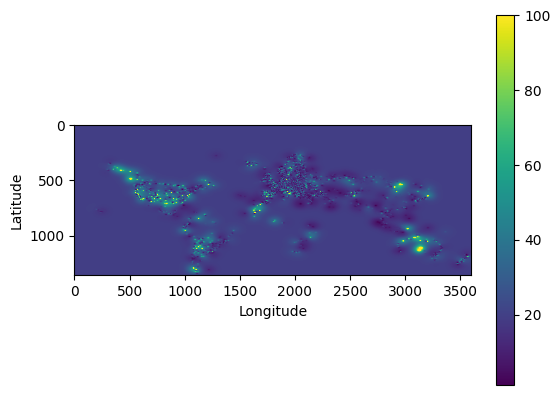

In [101]:
ds = load_dataset("tillwenke/heatchmap-map", cache_dir="intermediate/huggingface")
ds = ds.with_format("np")
image = ds["train"]["numpy"]
plt.imshow(image.clip(0,100), cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Downloaded Hitchmap data to: /home/till/miniconda3/envs/hitchmap-data/lib/python3.10/site-packages/heatchmap/cache/hitchmap/dump.sqlite


/home/till/miniconda3/envs/hitchmap-data/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/till/miniconda3/envs/hitchmap-data/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Countries dataset already exists at: /home/till/miniconda3/envs/hitchmap-data/lib/python3.10/site-packages/heatchmap/cache/countries/ne_110m_admin_0_countries.shp


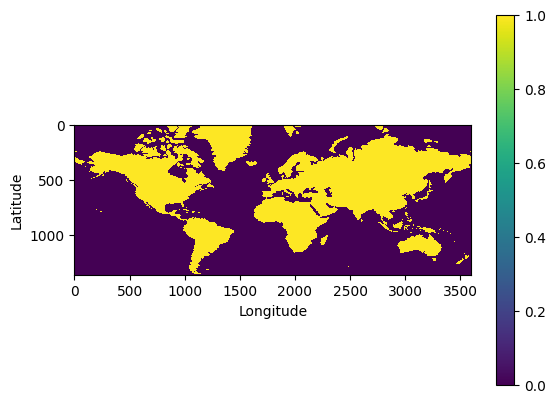

(1360, 3600)

In [102]:
from heatchmap.gpmap import GPMap
mymap = GPMap()
mymap.get_map_grid()
mymap.get_landmass_raster()
mymap.landmass_raster.shape

In [103]:
image = np.where(mymap.landmass_raster, image, np.nan)

In [104]:
image = norm(image).data

import numpy as np
import matplotlib.pyplot as plt

# Input 2D scalar array
scalars = image

# Apply the colormap to scalars
colors = cmap(scalars)

# Combine RGB values with the opacity
rgba_array = np.empty_like(colors)
rgba_array[:, :, :3] = colors[:, :, :3]  # RGB
rgba_array[:, :, 3] = 1.0  # A

# Verify shape and content
print(rgba_array.shape)

(1360, 3600, 4)


In [105]:
folium.raster_layers.ImageOverlay(
    image=rgba_array,
    bounds=[[-56, -180], [80, 180]],
).add_to(m)

/home/till/.local/lib/python3.10/site-packages/branca/utilities.py:329: RuntimeWarning: invalid value encountered in divide
  array = array * 255./array.max(axis=(0, 1)).reshape((1, 1, 4))
/home/till/.local/lib/python3.10/site-packages/branca/utilities.py:330: RuntimeWarning: invalid value encountered in cast
  array = array.astype('uint8')



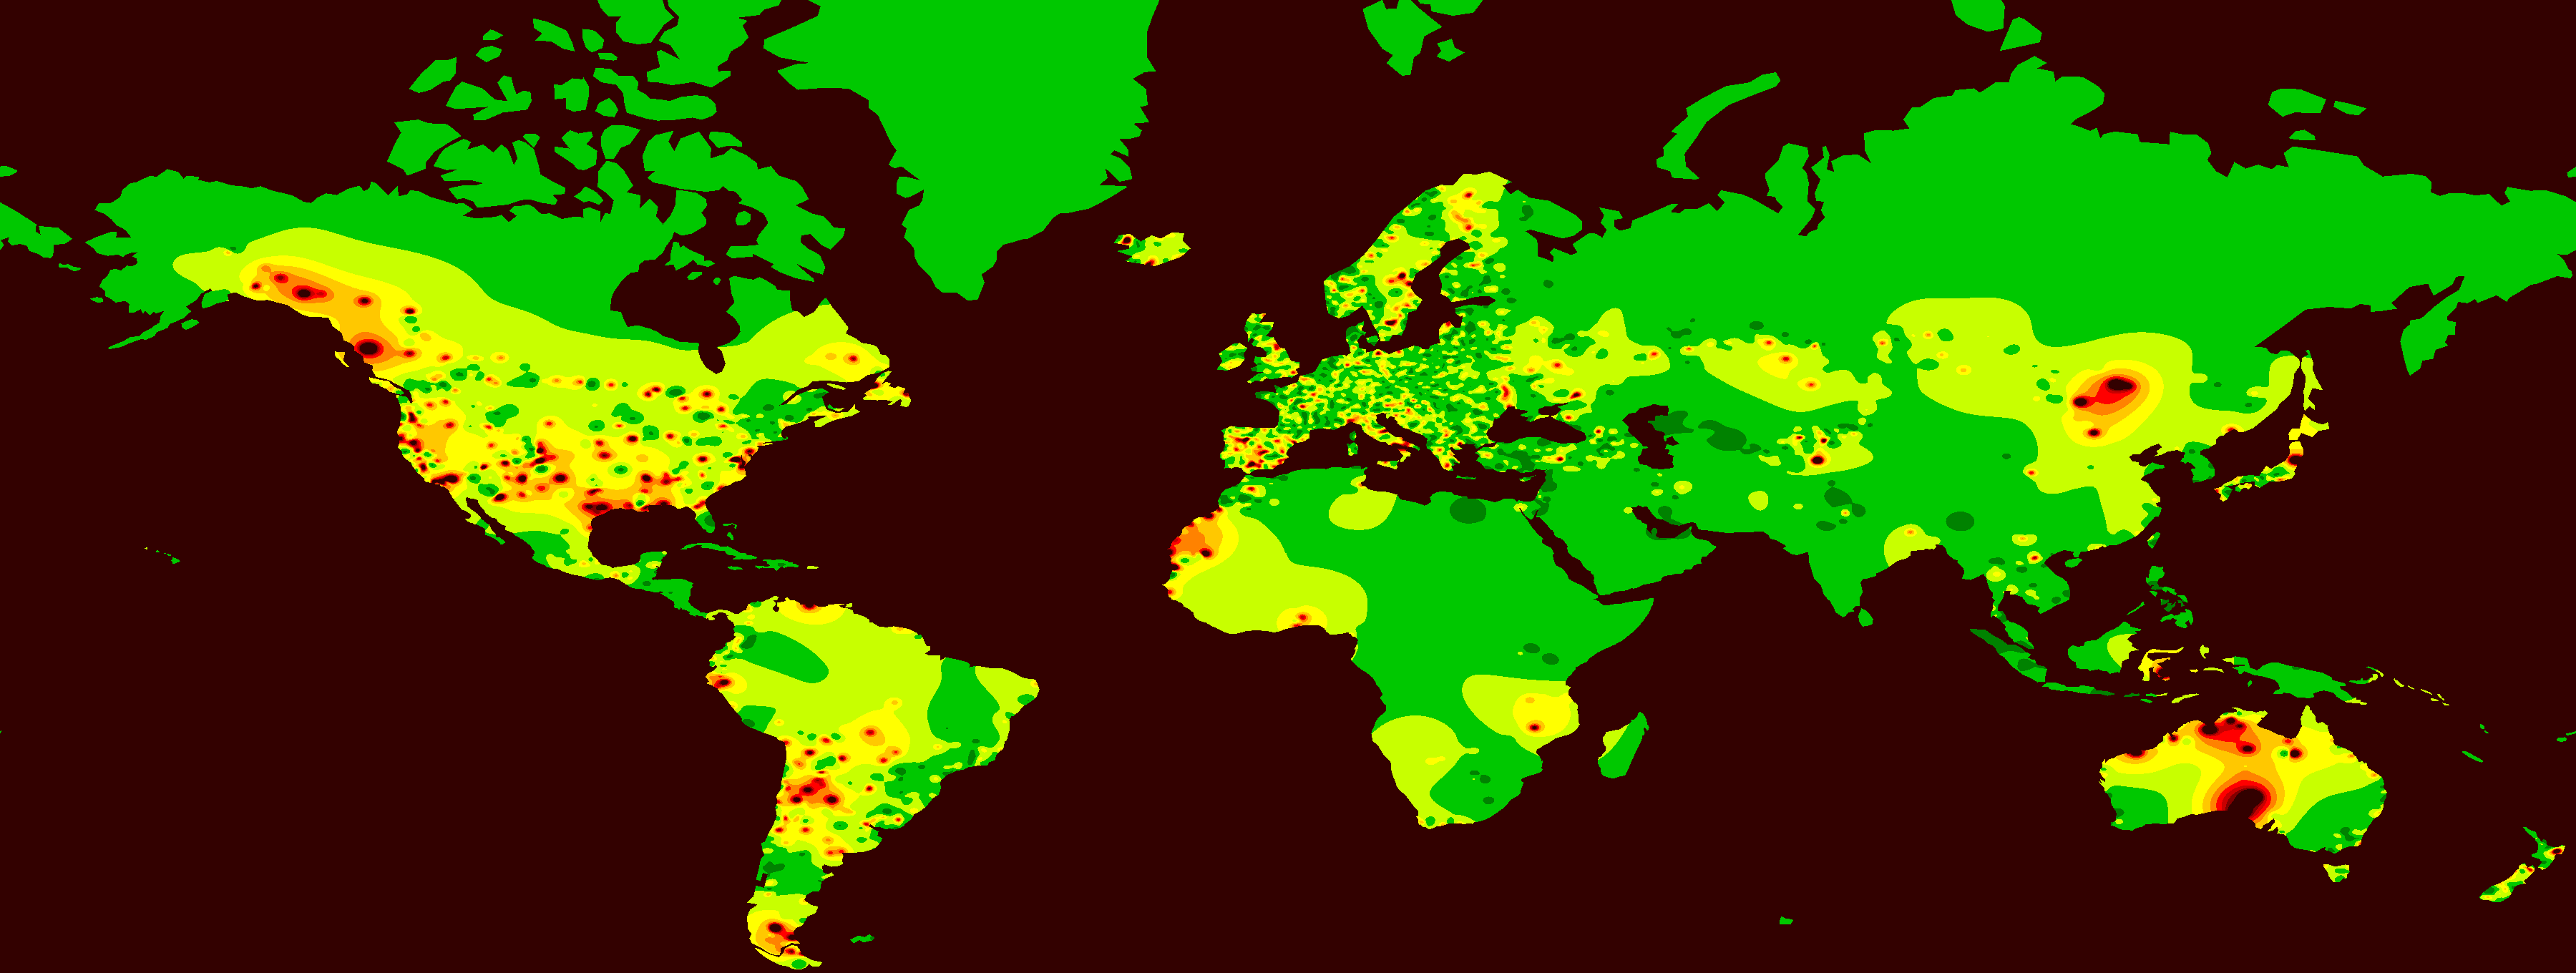

In [106]:
m

In [110]:
from string import Template
m.get_root().render()

header = m.get_root().header.render()
header = header.replace(
    '<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>',
    '<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css">',
)
header = header.replace(
    '<link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>',
    '<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css">',
)
body = m.get_root().html.render()
script = m.get_root().script.render()

outname = "hitchhiking.html"
template = open("src.html", encoding="utf-8").read()

output = Template(template).substitute(
    {
        "folium_head": header,
        "folium_body": body,
        "folium_script": script,
        "hitch_script": open("map.js", encoding="utf-8").read(),
        "hitch_style": open("style.css", encoding="utf-8").read(),
    }
)

open(outname, "w", encoding="utf-8").write(output)

194148